# Programming Lab 3 - Algorithm Exploration

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

In [0]:
name = 'Taylor Mallory'

***
# Load packages 
***

Add the packages you need here (not below!)

In [0]:
import pandas as pd
import numpy as np
assert name != '<replace with your name>'
from matplotlib import pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import tree
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from matplotlib import cm

***
# Background
***

In this lab, you will predict the emotional [valence and arousal](https://en.wikipedia.org/wiki/Emotion_classification#Circumplex_model) values for a dataset of 18k musical songs. 

* **Valence** describes the *attractiveness* (positive valence) or *aversiveness* (negative valence) of stimuli.

* **Arousal** refers to the perceived intensity of an event from very *calming* to highly *exciting* or *agitating*.

![alt text](https://image.slidesharecdn.com/w16-0404-170918170017/95/lyle-ungar-2016-modelling-valence-and-arousal-in-facebook-posts-4-638.jpg?cb=1505759747)

We want to answer the research question: 
> *Can the way people talk about music tell us something about the emotional quality of the music itself*?

In this lab, we attempt to predict the emotional quality of pieces of music based on Youtube comments about the music. 

***
# Overview
***

This is a **regression** task in which we predict both <font color="#DC4405">**valence**</font> and <font color="#DC4405">**arousal**</font>. We predict these values separately (one model for each) but we use the same algorithm (and parameters) for both valence and arousal.

Below, you are given several tasks to complete. You have broad flexibility in how you organize your code, choose which features to use, and to find and tune the best algorithm for the task. Make intelligent decisions and justify your choices in the lab report. 

This is a friendly class *competition* in which the goal is to find the best **Pearson's correlation** in the task of predicting valence and arousal. 

You will be graded on your report conveying your experiments, not on your code itself. 

***
# Data
***

The follow code downloads the data and loads the various files into several dataframes.  You should display and/or describe each dataframe to better understand the data.

In [0]:
# url of the data zip file
url = 'https://github.com/Soundbendor/cs434/raw/master/lab3-deezer.zip'

In [0]:
# fetch zip file (then comment out line)
# !wget $url

In [0]:
# unzip file (then comment out line)
# !unzip 'lab3-deezer.zip'

## Deezer metadata 

This is data about each song including our target valence and arousal values.

Row index ("primary key" across our data files):
* `MSD_track_id` stands for *million song dataset track id* ([more info](http://millionsongdataset.com/))

Metadata (drop before learning):
* `dzr_sng_id` : Deezer song id
* `MSD_sng_id` : MSD song id
* `artist_name` : artist name
* `track_name` : track name

Predictors (targets of our ML experiments):
* `valence` : valence value of the song
* `arousal` : arousal value of the song

Valence and arousal values for music are difficult to collect via expensive and time-consuiming human subject experiments.  

To create a large dataset, these valence and arousal values were synthetically estimated by the music streaming company [Deezer](https://www.deezer.com/us/) based off of tags from [last.fm](last.fm). There are 18,644 songs in the dataset. Their method is explained in their [academic paper](http://ismir2018.ircam.fr/doc/pdfs/99_Paper.pdf).

In [6]:
# Deezer metadata
df_meta = pd.read_csv('deezer_metadata.csv', index_col=0)
df_meta

,dzr_sng_id,MSD_sng_id,artist_name,track_name,valence,arousal
MSD_track_id,,,,,,
TRJIEJX12903CF2202,213754,SORORTY12A67ADD67E,Dark Tranquillity,Insanity's Crescendo,-0.682725,0.316758
TRLBHVY128F4242C31,216752,SOVJXGK12A8AE4760C,Anorexia Nervosa,Stabat mater dolorosa,-1.400403,1.538229
TRQJZHB128F92FA42D,239138,SOACXLC12AB018218D,Jimmy Witherspoon,Ain't Nobody's Business,-1.935250,-0.655810
TRCXLKK128F42366BF,254391,SOUTMGD12A8AE47448,Uniting Nations,Out Of Touch,0.815393,0.662457
TRPMWQM128F932C0C8,266313,SOTITAA12A6D4F8DA4,The Walkmen,Brandy alexander,1.257460,1.086515
...,...,...,...,...,...,...
TREQLLG128F935A6B5,111894158,SORPIXF12AB01868DD,Arch Enemy,Fields Of Desolation,-1.558674,1.883928
TRAMFAS12903CD7030,112680888,SOCIKSJ12AB018BEAB,Deepest Blue,Is It A Sin,-1.220301,0.644020
TRWSEAE128F93359C4,113204038,SOUPRMS12AB0182A08,The Zombies,I'll Call You Mine,1.178325,1.183311


## Youtube comments

This data was collected by Cascades student Blaize Guerra. We searched for Youtube videos of the 18,644 songs in the Deezer dataset.

 > We collected 4,675,245 comments from Youtube containing	73,122,499 words.


From these 73M words, I eliminated non-English characters and common (stop-) words. I then filtered the comments using several common words lists used in sentiment analysis. From the resulting words, I calculated various metrics that aggregated the sentiments of these words.

The following word lists were used:
* [NRC Valence, Arousal, and Dominance Lexicon](https://saifmohammad.com/WebPages/nrc-vad.html)
* [NRC Word-Emotion Association Lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)
* [NRC Emotion Intensity Lexicon](https://saifmohammad.com/WebPages/AffectIntensity.htm)
* [ANEW Affective Norms for English Words](https://www.uvm.edu/pdodds/teaching/courses/2009-08UVM-300/docs/others/everything/bradley1999a.pdf)
* [MPQA Subjectivity Lexicon](https://mpqa.cs.pitt.edu/lexicons/)
* [Hashtag Sentiment Corpus](http://saifmohammad.com/WebPages/SentimentEmotionLabeledData.html)

There are 60 features describing the emotion/sentiment of the Youtube comments for that song. 

In [7]:
# Youtube features
df_ytube = pd.read_csv('deezer_youtube.csv', index_col=0)
df_ytube

,yt_comment_n,yt_comment_len,yt_comment_len_mean,yt_comment_len_stdev,yt_words_clean_unique_n,yt_words_clean_total_n,yt_bsm_n_words,yt_bsm_v_mean,yt_bsm_v_std,yt_bsm_a_mean,yt_bsm_a_std,yt_bsm_d_mean,yt_bsm_d_std,yt_emo_n_words,yt_emo_v_total,yt_emo_v_mean,yt_emo_v_std,yt_emo_a_total,yt_emo_a_mean,yt_emo_a_std,yt_emo_d_total,yt_emo_d_mean,yt_emo_d_std,yt_aff_n_words,yt_aff_anger,yt_aff_fear,yt_aff_sadness,yt_aff_joy,yt_aff_anger_wt,yt_aff_fear_wt,yt_aff_sadness_wt,yt_aff_joy_wt,yt_lex_n_words,yt_lex_joy,yt_lex_trust,yt_lex_anticipation,yt_lex_surprise,yt_lex_positive,yt_lex_negative,yt_lex_sadness,yt_lex_fear,yt_lex_disgust,yt_hssent_n_words,yt_hssent_uniq_avg,yt_hssent_uniq_yt_std,yt_hssent_dupl_avg,yt_anew_n_words,yt_anew_v_total,yt_anew_v_mean,yt_anew_v_std,yt_anew_a_total,yt_anew_a_mean,yt_anew_a_std,yt_anew_d_total,yt_anew_d_mean,yt_anew_d_std,yt_mpqa_n_words,yt_mpqa_pos,yt_mpqa_neu,yt_mpqa_neg
MSD_track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRJIEJX12903CF2202,302.0,3982.0,13.185430,16.455277,1151.0,2451.0,464.0,6.031083,1.669278,4.331601,2.419647,5.714890,2.116766,506.0,0.633636,0.491142,0.547953,0.580016,0.251475,0.484621,0.190823,0.538126,0.177969,238.0,0.520477,0.556126,0.574806,0.560779,0.083199,0.114740,0.132483,0.226188,533.0,0.127119,0.108475,0.092373,0.075424,0.182203,0.110169,0.095763,0.092373,0.044068,1171.0,0.361597,1.369955,0.573697,464.0,6.031083,4.331601,5.714890,5.572694,1.460658,4.282866,0.967282,5.501853,1.029466,244.0,0.543243,0.214865,0.241892
TRLBHVY128F4242C31,123.0,2033.0,16.528455,30.120339,744.0,1379.0,228.0,6.103966,1.663582,4.297015,2.415991,5.832111,2.100618,249.0,0.647708,0.479348,0.552117,0.631763,0.231754,0.483835,0.174283,0.552892,0.177980,85.0,0.543650,0.520938,0.307361,0.575521,0.076035,0.058287,0.077378,0.285748,210.0,0.157303,0.123596,0.103933,0.050562,0.238764,0.106742,0.084270,0.039326,0.039326,665.0,0.312835,1.358115,0.457268,228.0,6.103966,4.297015,5.832111,5.869561,1.336728,4.239079,0.950347,5.698509,0.944585,121.0,0.530364,0.275304,0.194332
TRQJZHB128F92FA42D,95.0,1548.0,16.294737,16.116513,504.0,909.0,272.0,6.119290,1.692457,4.116276,2.419098,5.668791,2.125547,301.0,0.645706,0.438457,0.511699,0.625721,0.209672,0.468701,0.178163,0.529535,0.166042,93.0,0.512278,0.539091,0.397302,0.585701,0.054241,0.069765,0.123865,0.265288,251.0,0.142857,0.130326,0.097744,0.055138,0.240602,0.090226,0.120301,0.052632,0.027569,698.0,0.336066,1.280988,0.464510,272.0,6.119290,4.116276,5.668791,5.914228,1.232868,4.180699,0.876097,5.597610,0.876773,112.0,0.643564,0.212871,0.143564
TRCXLKK128F42366BF,350.0,3930.0,11.228571,24.194988,857.0,2166.0,396.0,6.264867,1.640017,4.264301,2.399867,5.779260,2.164201,428.0,0.667213,0.465629,0.520598,0.621437,0.220203,0.476428,0.183007,0.519477,0.162475,147.0,0.576727,0.390300,0.242109,0.583397,0.058380,0.035917,0.047531,0.356123,332.0,0.177778,0.106173,0.137037,0.059259,0.254321,0.097531,0.056790,0.034568,0.038272,1073.0,0.271705,1.208897,0.361069,396.0,6.264867,4.264301,5.779260,5.864268,1.325275,4.263662,0.980859,5.640732,0.922698,180.0,0.512356,0.369028,0.118616
TRPMWQM128F932C0C8,30.0,364.0,12.133333,11.714222,144.0,198.0,88.0,6.311129,1.674032,4.312016,2.462016,5.910323,2.063790,91.0,0.687197,0.488913,0.557819,0.643462,0.225914,0.479956,0.164002,0.540758,0.178077,26.0,0.514667,0.517750,0.394833,0.566364,0.044114,0.059171,0.067686,0.356000,63.0,0.193182,0.136364,0.079545,0.056818,0.227273,0.113636,0.056818,0.045455,0.056818,207.0,0.454768,1.287906,0.670788,88.0,6.311129,4.312016,5.910323,6.064091,1.301717,4.205795,0.827759,5.724091,0.889467,38.0,0.679245,0.188679,0.132075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TREQLLG128F935A6B5,119.0,1705.0,14.327731,21.249171,462.0,791.0,252.0,5.722469,1.636444,4.294916,2.424895,5.640816,2.127322,269.0,

## Spotify features

This data was collected by Corvallis student Shaurya Guar.  He queried the [Spotify API](https://developer.spotify.com/documentation/web-api/) for the 18,644 songs in the Deezer dataset.

There are 15 features describing the audio of the song.

In [8]:
# Spotify features
df_spot = pd.read_csv('deezer_spotify.csv', index_col=0)
df_spot

,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
MSD_track_id,,,,,,,,,,,,,,,
TRGVJCD128F42623E3,0.131000,0.460,278267.0,0.772,0.041700,0.0,0.0527,-9.233,1.0,0.0445,138.002,4.0,0.532,53.0,False
TRNXMAY128F931FAC6,0.394000,0.520,299613.0,0.253,0.000131,0.0,0.1090,-12.407,1.0,0.0344,139.555,3.0,0.219,60.0,False
TRYMZQJ128F426A0E7,0.056200,0.909,219840.0,0.740,0.000000,1.0,0.0593,-2.361,1.0,0.2600,97.855,4.0,0.802,54.0,True
TRZHHIL128F4264EE0,0.905000,0.701,223613.0,0.202,0.000157,1.0,0.1070,-12.480,1.0,0.0609,85.389,4.0,0.477,53.0,False
TRJEBIT128F933A400,0.818000,0.499,298237.0,0.201,0.000001,11.0,0.1430,-12.145,1.0,0.0276,72.139,4.0,0.234,48.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TREQLLG128F935A6B5,0.000090,0.174,209507.0,0.988,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,True
TRAMFAS12903CD7030,0.000019,0.693,513520.0,0.731,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,False
TRWSEAE128F93359C4,0.133000,0.533,156093.0,0.833,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,False


## Last.fm features

**IMPORTANT** : the last.fm data should not be used in the training your models (except in our Warmup experiment). 

Deezer used last.fm tags to synthetically generate the valence and arousal of their dataset. 

#### All tags
This is dataset of the 5000 most common last.fm tags.  It is a sparse binary matrix which indicates if each song (row) has the respective last.fm tag (column).

In [9]:
# Last FM tag
df_alltags = pd.read_csv('deezer_lastfm_all_tags.csv', index_col=0)
df_alltags

,00s,1,10s,131,1950s,1960s,1970s,1979,1980s,1982,1984,1990,1990s,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2000s,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,20th Century,21st century,2giveme5,3,3 star,3 stars,...,trumpet,turntablism,twee,umlaute,under two minutes,underground,underground hip hop,underground hip-hop,underrated,unique,upbeat,uplifting trance,urban,us,viking metal,violin,vocal,vocal house,vocal jazz,vocal trance,vocalization,vocals,warm,weallgetold,web-found,weird,west coast,winter,wistful,wonderful,work,world,world fusion,worship,wow,xmas,xynod,yeah,yes,MSD_track_id
-favorites-,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRJIEJX12903CF2202
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRLBHVY128F4242C31
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRQJZHB128F92FA42D
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRCXLKK128F42366BF
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRPMWQM128F932C0C8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TREQLLG128F935A6B5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRAMFAS12903CD7030
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TRWSEAE128F93359C4


#### Best tag

This data represents the most common tag associated with with each song on [last.fm](last.fm) if found, or *none* otherwise. 



Row index ("primary key" across data files):
* `MSD_track_id`

Features:
* `lastfm_tag` : string name of tag, or *none*.
* `lastfm_tag_rank` : rank of tag in MSD
  * 0 = none, 1 = most common, 2 = second most common, etc.


The `lastfm_tag` or the `lastfm_tag_rank` can be useful when visualizing your data (e.g., point color).

In [10]:
# Last FM best tag
df_tag = pd.read_csv('deezer_lastfm_best_tag.csv', index_col=0)
df_tag

,lastfm_tag,lastfm_tag_rank
MSD_track_id,,
TRZFLBZ128F92FF270,none,0
TRWBOSU128F4281471,none,0
TRFFYPU128F149A19D,none,0
TRWRAGX128E0784C84,none,0
TRAJPQC128F92E6018,none,0
...,...,...
TRYCFVF128F9302E9E,the goodbye song,498810
TRNNXFC128F931466A,the word barren,500920
TRAHDJA128E07967E7,the word sod,501681


## Song lyrics (for extra credit task)

This data represents the frequency of words in the lyrics to 13,526 of the songs. Each column represents a word and the value represents the proportion of that song's lyrics that match that word.  If a word was not present in the lyrics, it is 0. 

In [11]:
# Lyrics bag of words
df_lyrics = pd.read_csv('deezer_lyrics_binary.csv', index_col=0)
df_lyrics

,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,this,but,with,what,just,when,like,now,que,time,can,come,...,aquello,lucif,cruz,jamaica,flavor,kuinka,uit,24,anguish,foto,chat,jétai,caminho,observ,altro,javai,yang,oer,nickel,booz,sew,música,stai,naughti,entiendo,står,champion,forsak,seventh,capit,writer,motivo,bake,insist,wel,santo,pe,gee,colleg,kad
MSD_track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAABIG128F9356C56,0.034356,0.094479,0.038037,0.050307,0.006135,0.015951,0.000000,0.020859,0.006135,0.007362,0.051534,0.003681,0.040491,0.004908,0.003681,0.004908,0.002454,0.001227,0.000000,0.002454,0.000000,0.008589,0.001227,0.001227,0.000000,0.001227,0.003681,0.001227,0.001227,0.001227,0.002454,0.000000,0.002454,0.000000,0.012270,0.002454,0.001227,0.0,0.002454,0.007362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAABJS128F9325C99,0.047619,0.028571,0.028571,0.028571,0.076190,0.000000,0.009524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009524,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.019048,0.000000,0.009524,0.000000,0.000000,0.019048,0.000000,0.000000,0.000000,0.000000,0.009524,0.000000,0.019048,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAACER128F4290F96,0.015686,0.043137,0.074510,0.015686,0.015686,0.007843,0.011765,0.027451,0.007843,0.015686,0.007843,0.000000,0.011765,0.019608,0.000000,0.003922,0.000000,0.023529,0.015686,0.007843,0.019608,0.011765,0.003922,0.000000,0.011765,0.011765,0.000000,0.019608,0.003922,0.007843,0.003922,0.000000,0.000000,0.007843,0.000000,0.007843,0.000000,0.0,0.000000,0.007843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAADQX128F422B4CF,0.058394,0.029197,0.072993,0.029197,0.000000,0.007299,0.007299,0.036496,0.014599,0.000000,0.014599,0.007299,0.014599,0.014599,0.021898,0.000000,0.000000,0.007299,0.021898,0.000000,0.021898,0.007299,0.000000,0.000000,0.014599,0.029197,0.000000,0.014599,0.000000,0.000000,0.007299,0.000000,0.000000,0.000000,0.036496,0.000000,0.000000,0.0,0.007299,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAADVO128E07999E9,0.012121,0.054545,0.048485,0.042424,0.012121,0.006061,0.000000,0.042424,0.018182,0.000000,0.000000,0.024242,0.000000,0.000000,0.000000,0.006061,0.006061,0.012121,0.048485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024242,0.000000,0.018182,0.006061,0.000000,0.006061,0.000000,0.018182,0.018182,0.018182,0.000000,0.000000,0.0,0.000000,0.036364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRZWXMQ12903CE6AEF,0.034884,0.032946,0.034884,0.019380,0.025194,0.029070,0.003876,0.017442,0.019380,0.025194,0.017442,0.009690,0.013566,0.011628,0.021318,0.007752,0.011628,0.003876,0.015504,0.005814,0.000000,0.007752,0.001938,0.003876,0.003876,0.000000,0.007752,0.003876,0.000000,0.011628,0.025194,0.007752,0.003876,0.007752,0.005814,0.003876,0.000000,0.0,0.005814,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Graphing function

This is a provided function you should use to scatterplot data. 

In [0]:
# scatterplot predictions
def plot_data(x, y, x_label, y_label, title, colors='b', plt_size=14, dot_size=20, val_vs_aro=False) :
  plt.figure(figsize=(plt_size,plt_size))
  plt.scatter(x, y, s=dot_size, c=colors, alpha=.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # if valence vs arousal
  if val_vs_aro:
    plt.xlim(-1.25,1.25)
    plt.ylim(-1.25,1.25)   

    # draw the unit circle
    fig = plt.gcf()
    ax = fig.gca()
    circle1 = plt.Circle((0, 0), 1.0, color='0.25', fill=False)
    ax.add_artist(circle1)

    # print emotion labels
    plt.text(0.98, 0.35, 'Happy', fontsize=plt_size)
    plt.text(0.5, 0.9, 'Excited', fontsize=plt_size)
    plt.text(-1.16, 0.35, 'Afraid', fontsize=plt_size)
    plt.text(-0.7, 0.9, 'Angry', fontsize=plt_size)
    plt.text(-1.13, -0.25, 'Sad', fontsize=plt_size)
    plt.text(-0.9, -0.9, 'Depressed', fontsize=plt_size)
    plt.text(0.98, -0.25, 'Content', fontsize=plt_size)
    plt.text(0.7, -0.9, 'Calm', fontsize=plt_size)
    
  else:
    # true valence vs predicted valence, or 
    # true arousal vs predicted arousal, so
    #   draw the regression line
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red', linewidth=2)    

  plt.show()

You can use it two ways:

1. Valence (`x`-axis) vs Arousal (`y`-axis)
```python
# example usage, mapping the lastfm_tag to 20 colors
plot_data(df['valence'], df['arousal'], 'Valence', 'Arousal', 'True Valence vs. True Arousal', 
             colors=df['tag_rank']%20, val_vs_aro=True)
```
Note: `val_vs_aro=True`


2. True value (`x`-axis) vs Predicted value (`y`-axis) for either Valence or Arousal
```python
# example usage
plot_data(y, y_preds, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence',  plt_size=10)
```
Note: `val_vs_aro=False` (do not graph unit circle and emotion labels)

***
# Pre-work Tasks
***

## A: Data preprocessing

#### A.1 Normalize valence and arousal

The valence and arousal values in `df_meta` have already been standardized. However, we want to normalize these values in the range $(-1, 1)$ for graphing.

In [13]:
print(df_meta)
df_meta[['valence', 'arousal']] = minmax_scale(df_meta[['valence', 'arousal']], feature_range=(-1, 1))
df_meta


                    dzr_sng_id          MSD_sng_id  ...   valence   arousal
MSD_track_id                                        ...                    
TRJIEJX12903CF2202      213754  SORORTY12A67ADD67E  ... -0.682725  0.316758
TRLBHVY128F4242C31      216752  SOVJXGK12A8AE4760C  ... -1.400403  1.538229
TRQJZHB128F92FA42D      239138  SOACXLC12AB018218D  ... -1.935250 -0.655810
TRCXLKK128F42366BF      254391  SOUTMGD12A8AE47448  ...  0.815393  0.662457
TRPMWQM128F932C0C8      266313  SOTITAA12A6D4F8DA4  ...  1.257460  1.086515
...                        ...                 ...  ...       ...       ...
TREQLLG128F935A6B5   111894158  SORPIXF12AB01868DD  ... -1.558674  1.883928
TRAMFAS12903CD7030   112680888  SOCIKSJ12AB018BEAB  ... -1.220301  0.644020
TRWSEAE128F93359C4   113204038  SOUPRMS12AB0182A08  ...  1.178325  1.183311
TRQSIQV128F93085B3   117581660  SOIIDJM12AB017AFEB  ... -0.793515 -0.202252
TRKUOAS128F1478DC9   117581964  SOEUIUI12A58A7CD98  ...  0.373325 -0.923151

[18644 rows

,dzr_sng_id,MSD_sng_id,artist_name,track_name,valence,arousal
MSD_track_id,,,,,,
TRJIEJX12903CF2202,213754,SORORTY12A67ADD67E,Dark Tranquillity,Insanity's Crescendo,-0.206795,0.041667
TRLBHVY128F4242C31,216752,SOVJXGK12A8AE4760C,Anorexia Nervosa,Stabat mater dolorosa,-0.595273,0.521739
TRQJZHB128F92FA42D,239138,SOACXLC12AB018218D,Jimmy Witherspoon,Ain't Nobody's Business,-0.884786,-0.340580
TRCXLKK128F42366BF,254391,SOUTMGD12A8AE47448,Uniting Nations,Out Of Touch,0.604136,0.177536
TRPMWQM128F932C0C8,266313,SOTITAA12A6D4F8DA4,The Walkmen,Brandy alexander,0.843427,0.344203
...,...,...,...,...,...,...
TREQLLG128F935A6B5,111894158,SORPIXF12AB01868DD,Arch Enemy,Fields Of Desolation,-0.680945,0.657609
TRAMFAS12903CD7030,112680888,SOCIKSJ12AB018BEAB,Deepest Blue,Is It A Sin,-0.497784,0.170290
TRWSEAE128F93359C4,113204038,SOUPRMS12AB0182A08,The Zombies,I'll Call You Mine,0.800591,0.382246



#### A.2 Merge dataframes
* [Set 1] : `df_meta`, `df_alltags` and save as `df_lastfm_feats`
* [Set 2] : `df_meta`, `df_tag`, and `df_ytube` and save as `df_ytube_feats`
* [Set 3] : `df_meta`, `df_tag`, and `df_spot` and save as `df_spot_feats`
* [Set 4] : `df_meta`, `df_tag`, `df_ytube`, and `df_spot` and save as `df_all_feats`

In [14]:
df_lastfm_feats = pd.merge(df_meta, df_alltags, on='MSD_track_id')

inter = pd.merge(df_meta, df_tag, on='MSD_track_id')
df_ytube_feats = pd.merge(inter, df_ytube, on='MSD_track_id')

df_spot_feats = pd.merge(inter, df_spot, on='MSD_track_id')

df_all_feats = pd.merge(df_ytube_feats, df_spot, on='MSD_track_id')
df_all_feats

,dzr_sng_id,MSD_sng_id,artist_name,track_name,valence,arousal,lastfm_tag,lastfm_tag_rank,yt_comment_n,yt_comment_len,yt_comment_len_mean,yt_comment_len_stdev,yt_words_clean_unique_n,yt_words_clean_total_n,yt_bsm_n_words,yt_bsm_v_mean,yt_bsm_v_std,yt_bsm_a_mean,yt_bsm_a_std,yt_bsm_d_mean,yt_bsm_d_std,yt_emo_n_words,yt_emo_v_total,yt_emo_v_mean,yt_emo_v_std,yt_emo_a_total,yt_emo_a_mean,yt_emo_a_std,yt_emo_d_total,yt_emo_d_mean,yt_emo_d_std,yt_aff_n_words,yt_aff_anger,yt_aff_fear,yt_aff_sadness,yt_aff_joy,yt_aff_anger_wt,yt_aff_fear_wt,yt_aff_sadness_wt,yt_aff_joy_wt,...,yt_lex_anticipation,yt_lex_surprise,yt_lex_positive,yt_lex_negative,yt_lex_sadness,yt_lex_fear,yt_lex_disgust,yt_hssent_n_words,yt_hssent_uniq_avg,yt_hssent_uniq_yt_std,yt_hssent_dupl_avg,yt_anew_n_words,yt_anew_v_total,yt_anew_v_mean,yt_anew_v_std,yt_anew_a_total,yt_anew_a_mean,yt_anew_a_std,yt_anew_d_total,yt_anew_d_mean,yt_anew_d_std,yt_mpqa_n_words,yt_mpqa_pos,yt_mpqa_neu,yt_mpqa_neg,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
MSD_track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRJIEJX12903CF2202,213754,SORORTY12A67ADD67E,Dark Tranquillity,Insanity's Crescendo,-0.206795,0.041667,Melodic Death Metal,189,302.0,3982.0,13.185430,16.455277,1151.0,2451.0,464.0,6.031083,1.669278,4.331601,2.419647,5.714890,2.116766,506.0,0.633636,0.491142,0.547953,0.580016,0.251475,0.484621,0.190823,0.538126,0.177969,238.0,0.520477,0.556126,0.574806,0.560779,0.083199,0.114740,0.132483,0.226188,...,0.092373,0.075424,0.182203,0.110169,0.095763,0.092373,0.044068,1171.0,0.361597,1.369955,0.573697,464.0,6.031083,4.331601,5.714890,5.572694,1.460658,4.282866,0.967282,5.501853,1.029466,244.0,0.543243,0.214865,0.241892,0.001620,0.315,412000.0,0.7950,0.196000,6.0,0.0776,-9.645,0.0,0.0574,138.293,3.0,0.413,18.0,False
TRLBHVY128F4242C31,216752,SOVJXGK12A8AE4760C,Anorexia Nervosa,Stabat mater dolorosa,-0.595273,0.521739,black metal,172,123.0,2033.0,16.528455,30.120339,744.0,1379.0,228.0,6.103966,1.663582,4.297015,2.415991,5.832111,2.100618,249.0,0.647708,0.479348,0.552117,0.631763,0.231754,0.483835,0.174283,0.552892,0.177980,85.0,0.543650,0.520938,0.307361,0.575521,0.076035,0.058287,0.077378,0.285748,...,0.103933,0.050562,0.238764,0.106742,0.084270,0.039326,0.039326,665.0,0.312835,1.358115,0.457268,228.0,6.103966,4.297015,5.832111,5.869561,1.336728,4.239079,0.950347,5.698509,0.944585,121.0,0.530364,0.275304,0.194332,0.000010,0.171,440320.0,0.7980,0.029500,11.0,0.0759,-5.548,0.0,0.0622,110.058,4.0,0.130,19.0,False
TRQJZHB128F92FA42D,239138,SOACXLC12AB018218D,Jimmy Witherspoon,Ain't Nobody's Business,-0.884786,-0.340580,blues,34,95.0,1548.0,16.294737,16.116513,504.0,909.0,272.0,6.119290,1.692457,4.116276,2.419098,5.668791,2.125547,301.0,0.645706,0.438457,0.511699,0.625721,0.209672,0.468701,0.178163,0.529535,0.166042,93.0,0.512278,0.539091,0.397302,0.585701,0.054241,0.069765,0.123865,0.265288,...,0.097744,0.055138,0.240602,0.090226,0.120301,0.052632,0.027569,698.0,0.336066,1.280988,0.464510,272.0,6.119290,4.116276,5.668791,5.914228,1.232868,4.180699,0.876097,5.597610,0.876773,112.0,0.643564,0.212871,0.143564,0.924000,0.579,360640.0,0.0972,0.001050,10.0,0.0766,-13.925,1.0,0.0477,78.526,4.0,0.354,9.0,False
TRCXLKK128F42366BF,254391,SOUTMGD12A8AE47448,Uniting Nations,Out Of Touch,0.604136,0.177536,dance,9,350.0,3930.0,11.228571,24.194988,857.0,2166.0,396.0,6.264867,1.640017,4.264301,2.399867,5.779260,2.164201,428.0,0.667213,0.465629,0.520598,0.621437,0.220203,0.476428,0.183007,0.519477,0.162475,147.0,0.576727,0.390300,0.242109,0.583397,0.058380,0.035917,0.047531,0.356123,...,0.137037,0.059259,0.254321,0.097531,0.056790,0.034568,0.038272,1073.0,0.271705,1.208897,0.361069,396.0,6.264867,4.264301,5.779260,5.864268,1.325275,4.263662,0.980859,5.640732,0.922698,180.0,0.512356,0.369028,0.118616,0.008590,0.710,171747.0,0.9630,

#### A.3 Impute the mean for any missing values

In [15]:
df_lastfm_feats.isna().sum().sum() + df_ytube_feats.isna().sum().sum() + df_spot_feats.isna().sum().sum() + df_all_feats.isna().sum().sum()

df_ytube_feats = df_ytube_feats.fillna(df_ytube_feats.mean())
df_spot_feats = df_spot_feats.fillna(df_spot_feats.mean())
df_all_feats = df_all_feats.fillna(df_all_feats.mean())

df_lastfm_feats.isna().sum().sum() + df_ytube_feats.isna().sum().sum() + df_spot_feats.isna().sum().sum() + df_all_feats.isna().sum().sum()

0

#### A.4 Function to split `X` and `y`

For your different experiments, you will have make various `X` and `y` splits from above sets of data. `X` will be the features for training/testing and `y` will be the true values of either `'valence'` or `'arousal'`.

Here you should make yourself a helper function to split `X` and `y` depending on a given dataframe and desired predictor (valence or arousal).

**Reminder** : `'MSD_track_id'`, `'Deezer song id'`, `'MSD_sng_id'`, `'artist_name'`, `'track_name'`,  `'lastfm_tag'`, `'lastfm_tag_rank'`, `'valence'`, and `'arousal'` should not be used in training models. You don't have to drop them, but make sure not to include them in `X`.

In [0]:
def splitter(df, predictor='valence'):
  not_included = ['MSD_track_id', 'Deezer song id', 'dzr_sng_id', 'MSD_sng_id', 'artist_name', 'track_name', 'lastfm_tag', 'lastfm_tag_rank', 'valence', 'arousal']
  X = df[df.columns.difference(not_included)].values
  if(predictor == 'valence'):
    y = df['valence'].values
  else:
    y = df['arousal'].values
  return X, y

In [17]:
print(df_all_feats)
X, y = splitter(df_all_feats, predictor='arousal')
print(X.shape, y.shape)

                    dzr_sng_id          MSD_sng_id  ... sp_popularity sp_explicit
MSD_track_id                                        ...                          
TRJIEJX12903CF2202      213754  SORORTY12A67ADD67E  ...          18.0       False
TRLBHVY128F4242C31      216752  SOVJXGK12A8AE4760C  ...          19.0       False
TRQJZHB128F92FA42D      239138  SOACXLC12AB018218D  ...           9.0       False
TRCXLKK128F42366BF      254391  SOUTMGD12A8AE47448  ...          51.0       False
TRPMWQM128F932C0C8      266313  SOTITAA12A6D4F8DA4  ...          22.0       False
...                        ...                 ...  ...           ...         ...
TREQLLG128F935A6B5   111894158  SORPIXF12AB01868DD  ...          27.0        True
TRAMFAS12903CD7030   112680888  SOCIKSJ12AB018BEAB  ...          22.0       False
TRWSEAE128F93359C4   113204038  SOUPRMS12AB0182A08  ...          23.0       False
TRQSIQV128F93085B3   117581660  SOIIDJM12AB017AFEB  ...          75.0       False
TRKUOAS128F1478D

## B. Build learning function



> Using $k$-fold cross-validation, this function finds a prediction for each song in set of `X` and `y` and determines the average Pearson's correlation score across folds.

Write a function `train_and_test_CV` that 

1. build `k` folds with `KFold` partitions on `X` and `y`
2. enumerate over the folds
 * train `clf` on the train fold
 * predict `clf` on the test fold
 * find predictions for the fold, append to list of predictions
 * find the Pearson's correlation score on the fold, save in list
3. return list of `y_preds` and the average Pearson correlation.

```python
# usage
y_preds, pearson_corr = train_and_test_CV(clf, X, y, k=4)
```

This is a general function we reuse in a variety of experiments, for both valence and arousal prediction (depending on the target `y` passed).

In [0]:
def train_and_test_CV(clf, X, y, k=4):
  kfold = KFold(n_splits=k).split(X, y)
  y_preds = []
  pearson_corrs = []
  for k, (train, test) in enumerate(kfold):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    y_preds.extend(y_pred)
    p_corr, _ = pearsonr(y[test], y_pred)
    pearson_corrs.append(p_corr)

  return y_preds, sum(pearson_corrs)/len(pearson_corrs)

## C. Warmup Experiment

The Deezer valence-arousal values were estimated based on the valence-arousal of the words in last.fm tags. We can confirm this relationship though machine learning (i.e. predict valence-arousal based on last.fm tags).

#### C.1 Predict valence-arousal from last.fm tags

Use a `RandomForestRegressor` to predict both valence and arousal from   `df_lastfm_feats` [Set 1].

In [19]:
# valence
vX, vy = splitter(df_lastfm_feats)
clf = RandomForestRegressor(n_estimators=4)
vy_preds, pear = train_and_test_CV(clf, vX, vy, k = 4)
print(pear)

# arousal
aX, ay = splitter(df_lastfm_feats, predictor='arousal')
clf = RandomForestRegressor(n_estimators=4)
ay_preds, pear = train_and_test_CV(clf, vX, vy, k = 4)
print(pear)

0.9117006524604404
0.915717739544399


#### C.2 Graph your predictions for both valence and arousal and note your Pearson correlation.

> Since the last.fm tags were used to create the Deezer valence-arousal, we expect a very high correlation ($>0.90$).
> 
> We will not use the `lastfm` tags [Set 1] for the remainder of this Lab.

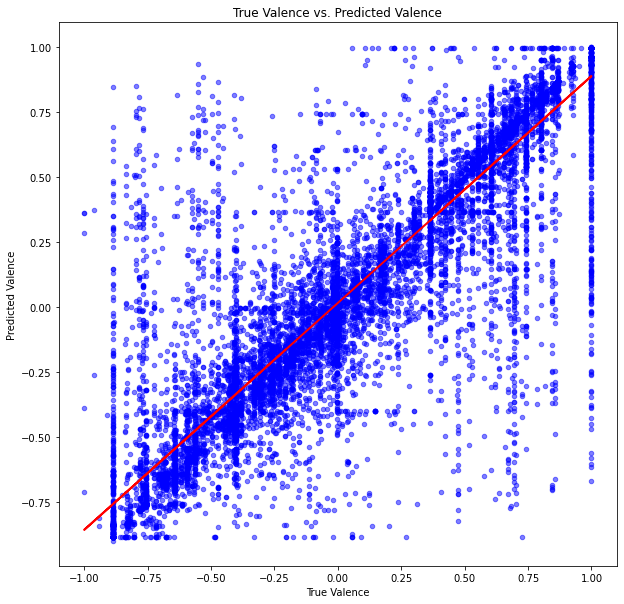

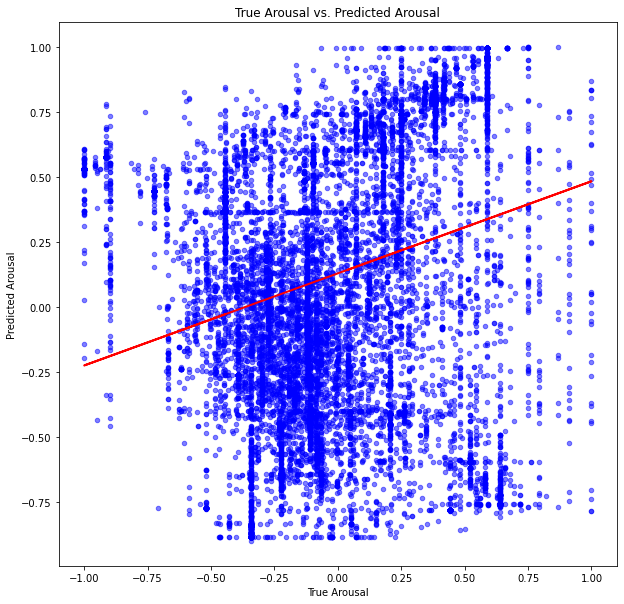

In [20]:
plot_data(vy, vy_preds, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence',  plt_size=10)
plot_data(ay, ay_preds, 'True Arousal', 'Predicted Arousal', 'True Arousal vs. Predicted Arousal',  plt_size=10)

***
# Experiments
***

> **PROTIP** : You will complete your experiments here and test your models.  But write your code as functions so that you can call them (again) later in the report section.  

For all experiments, use Cross-Validation so that we receive a predication for each song. You may decide which value of $k$ to use ($k>1$). 

Whereever relevant, use `random_state=1`.

## Experiment #1 - Model Selection

* Consider the first 1000 records from [Set 2] `df_ytube_feats`. We will use this subset to find a "best model".

* Choose three (or more) regressors from https://scikit-learn.org/stable/supervised_learning.html.

* Choose a value of $k$ for cross-validation.

* Tune your models. You may use any technique we have learned so far including (but not limited to):
  * dropping features, standardizing features, feature selection, dimensionality reduction (PCA), and/or parameter grid-search.

* Compare and determine the best model and parameters that work best for both valence and arousal.

> **Note**: Many of the songs have the exact same valence and arousal values (because of the method used to generate them).  This will result in some vertical lines in your prediction graphs because many have the same true (x-axis) valence or arousal value.

In [0]:
def exp1(df, pred, k=4):
  classifiers = [linear_model.Ridge(), tree.DecisionTreeRegressor(), svm.SVR()]

  linear_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}
  dt_params = {'max_depth': range(2,16,2), 'min_samples_split': range(2,16,2)}
  svm_params = param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
  param_grid = [linear_params, dt_params, svm_params]

  X, y = splitter(df, predictor=pred)
  pears = []
  y_bois = []
  best_params = {}
  for i in range(len(classifiers)):
    y_preds, pear = train_and_test_CV(classifiers[i], X, y, k= k)
    y_bois.append(y_preds)
    pears.append(pear)

  X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.30,
                     random_state=1)
  
  
  for i in range(len(param_grid)):
    clf = GridSearchCV(classifiers[i], param_grid= param_grid[i])
    result = clf.fit(X_train, y_train)
    best_params[str(classifiers[i])] = result.best_params_

  print('pearson correlation (untuned hyperparameters): \n')
  for i in range(len(classifiers)):
    print(classifiers[i])
    print("correlation: " + str(pears[i]) + " \n")
  
  print(" \n\n\n")
  print('best params \n')
  for v in best_params:
    print(v.split('(')[0], best_params[v])

  classifiers = [linear_model.Ridge(alpha=200), tree.DecisionTreeRegressor(max_depth=2, min_samples_split=2), svm.SVR(C=10.0, gamma=1)]
  pears = []
  y_bois = []
  best_params = {}
  for i in range(len(classifiers)):
    y_preds, pear = train_and_test_CV(classifiers[i], X, y, k= k)
    y_bois.append(y_preds)
    pears.append(pear)
  
  print(" \n\n\n")
  print('tuned pearson correlation: \n')
  for i in range(len(classifiers)):
    print(classifiers[i])
    print("correlation: " + str(pears[i]) + " \n")
  return max(pears)

In [22]:
band = df_ytube_feats.head(1000)
k = 6
print('='*10 + 'VALENCE'+ '='*10)
max_v = exp1(band, 'valence', k)
print('='*10 + 'AROUSAL'+ '='*10)
max_a = exp1(band, 'valence', k)


==========VALENCE==========
pearson correlation (untuned hyperparameters): 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
correlation: 0.2578312864388951 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
correlation: 0.13201635315992744 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
correlation: 0.05759003215787212 

 



best params 

Ridge {'alpha': 200}
DecisionTreeRegressor {'max_depth': 2, 'min_samples_split': 2}
SVR {'C': 10.0, 'gamma': 1.0}


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 



tuned pearson correlation: 

Ridge(alpha=200, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
correlation: 0.2686495539953608 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
correlation: 0.24363263026568283 

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
correlation: nan 

==========AROUSAL==========
pearson correlation (untuned hyperparameters): 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 



tuned pearson correlation: 

Ridge(alpha=200, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
correlation: 0.2686495539953608 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
correlation: 0.24363263026568283 

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
correlation: nan 



## Experiment #2 - Feature Comparison

* Use your best model and parameters from Experiment #1.

* Use all the records for each dataset (not just first 1000).

* Find the Pearson correlation for our three datasets for both valence and arousal.
 * `df_ytube_feats` [Set 2] : youtube features
 * `df_spot_feats` [Set 3] : spotify features
 * `df_all_feats` [Set 4] : both youtube and spotify features

* For each dataset, graph:
  * true valence vs predicted valence (dot color, your choice)
  * true arousal vs predicted arousal (dot color, your choice)
  * predicted valence vs predicted arousal
    * dot color should be based on error between true and predicted 
      * e.g., green might mean a small error, but dark red might mean a very large error
    * choose a method to aggregate valence and arousal error together
      * e.g., sum of error, max of error, square of error, etc.

* Answer the research question: 
> Which set of features is best to predict valence and arousal? 
>
> * *youtube comments, spotify features, or the combination of both?*


It seems a combination of both has the most concise clustering and least amount of errors, but I'm also worried I might have done something wrong or am misinterpreting things.




In [0]:
def exp2(best_clf, datasets=[]):
  pears = []
  labels = ['valence', 'arousal']
  mse = {}
  for d in datasets:
    print('='*15 + str(d.name) + '='*15)
    for l in labels: 
      vc = []
      ac = []
      X, y = splitter(d, predictor= l)
      if(l == 'valence'):
        vy_pred, pear = train_and_test_CV(best_clf, X, y)
        plot_data(y, vy_pred, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence',  plt_size=5)
      else:
        ay_pred, pear = train_and_test_CV(best_clf, X, y)
        plot_data(y, ay_pred, 'True Arousal', 'Predicted Arousal', 'True Arousal vs. Predicted Arousal',  plt_size=5)
      for i in range(len(ay_preds)):
        vc.append(abs(y[i]) - abs(vy_preds[i]))
        ac.append(abs(y[i]) - abs(ay_preds[i]))
      plot_data(vy_preds, ay_preds, 'Valence', 'Arousal', 'Predicted Valence vs. Predicted Arousal', 
          colors=vc, val_vs_aro=True)
    vc = np.array(vc)
    ac = np.array(ac)
    mse[str(d.name) + ' valence mse'] =  np.mean((vc)**2)
    mse[str(d.name) + ' arousal mse'] = np.mean((ac)**2)
  print('TODO FIX BELOW :(')
  for v in mse:
    print(v, mse[v])
      

===============df_ytube_feats===============


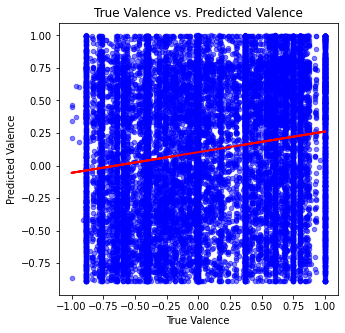

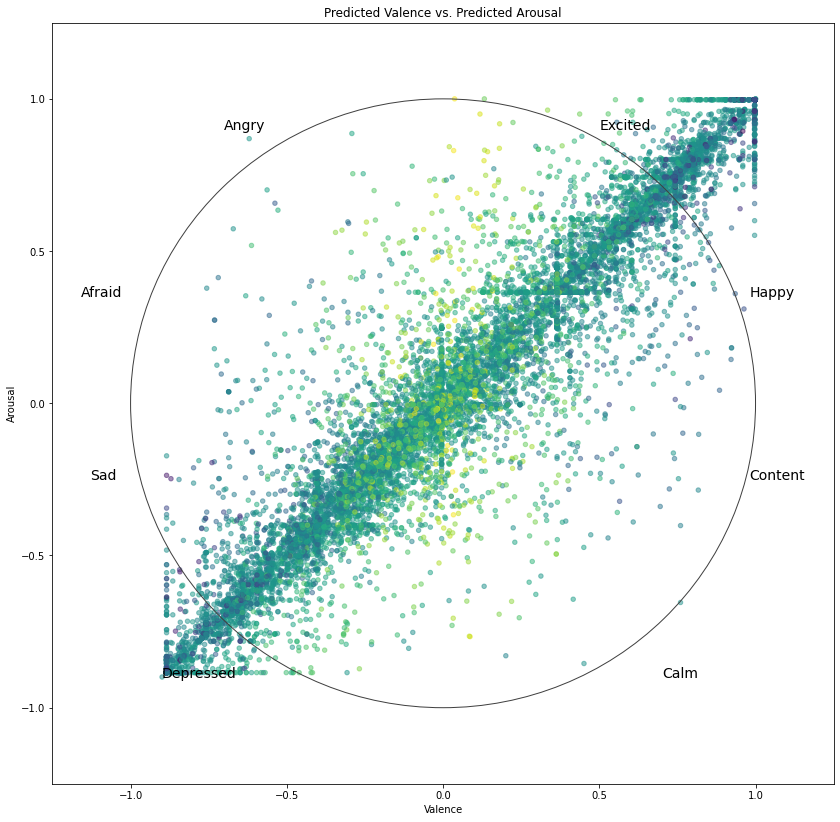

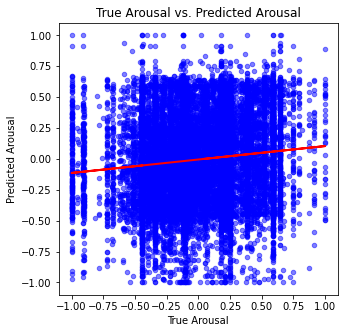

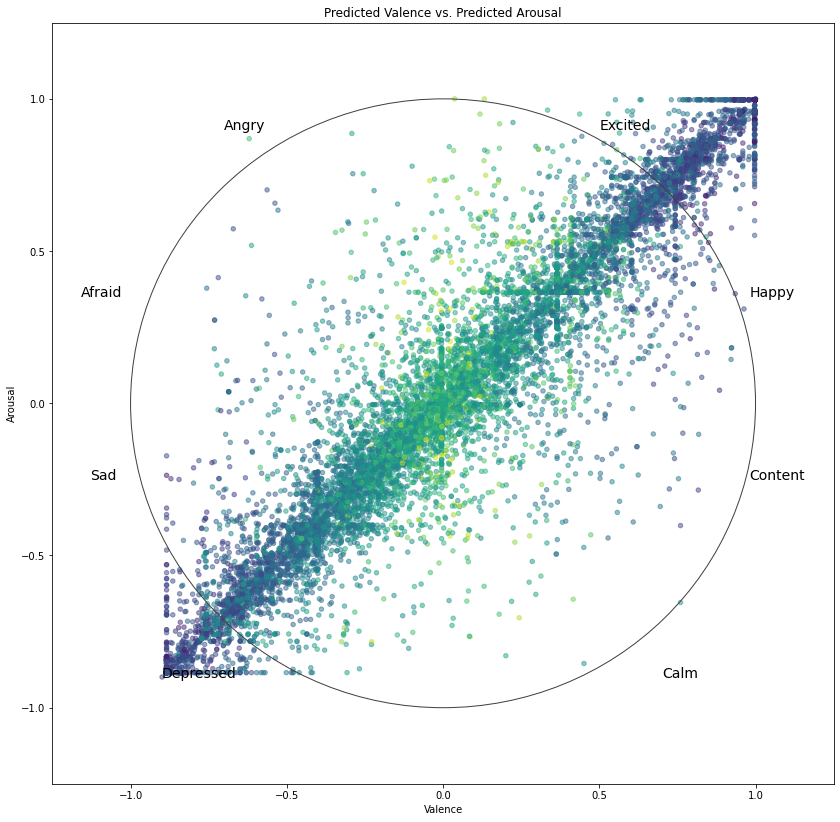

===============df_spot_feats===============


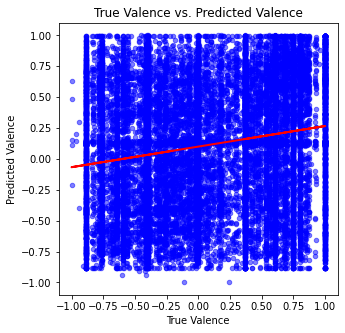

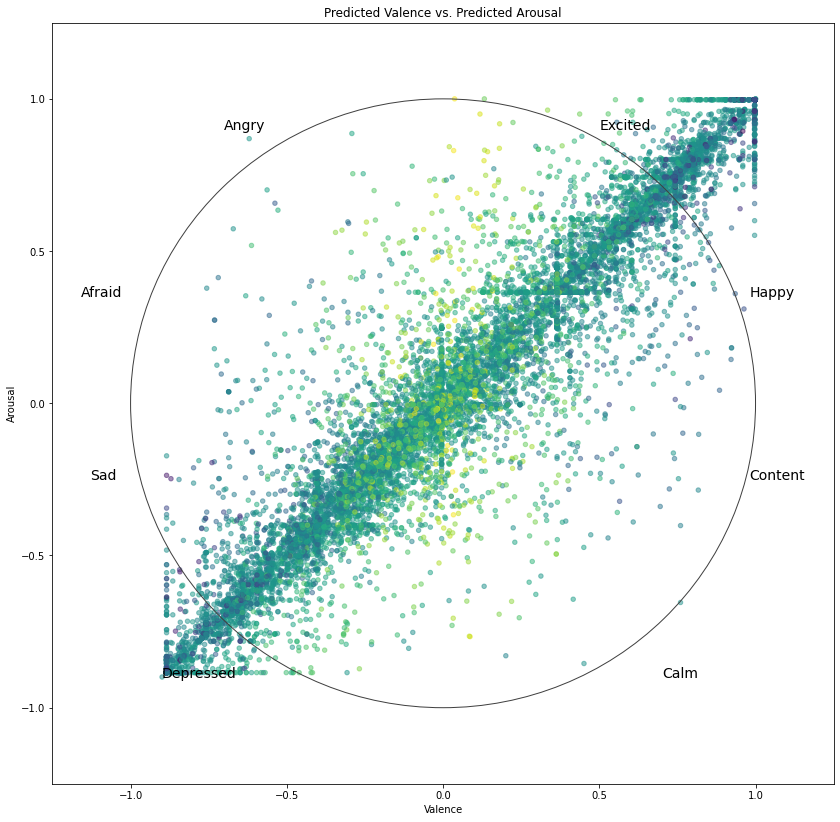

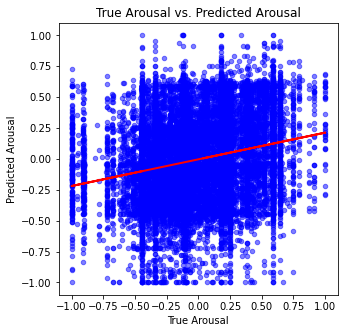

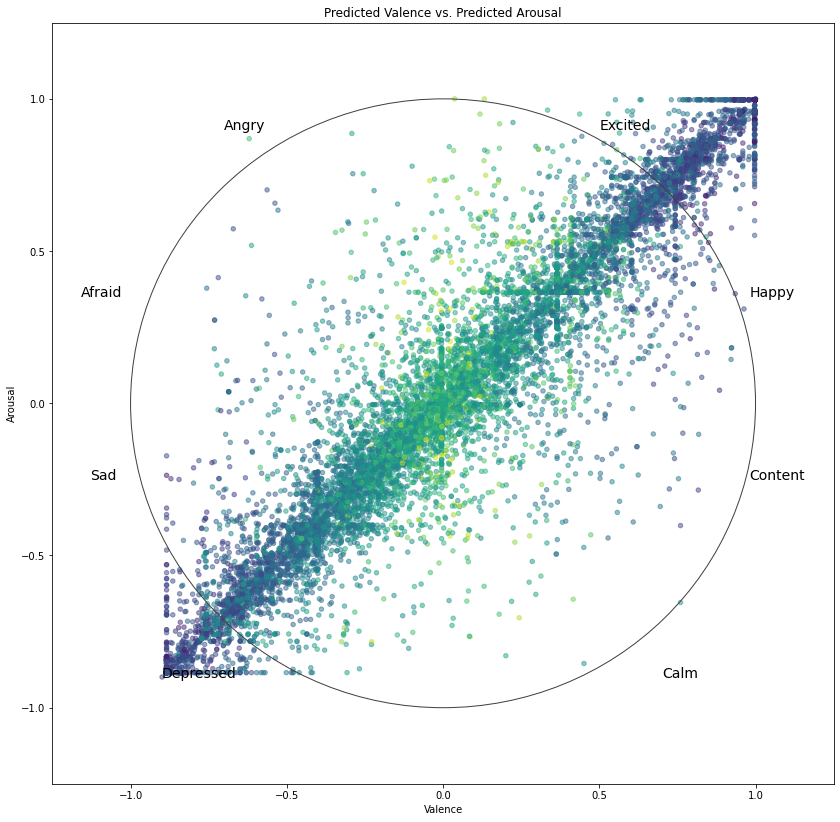

===============df_all_feats===============


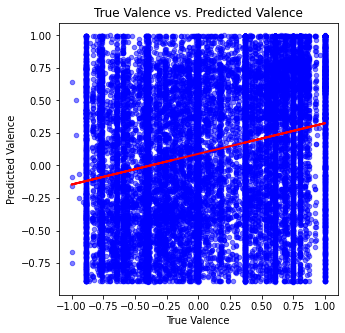

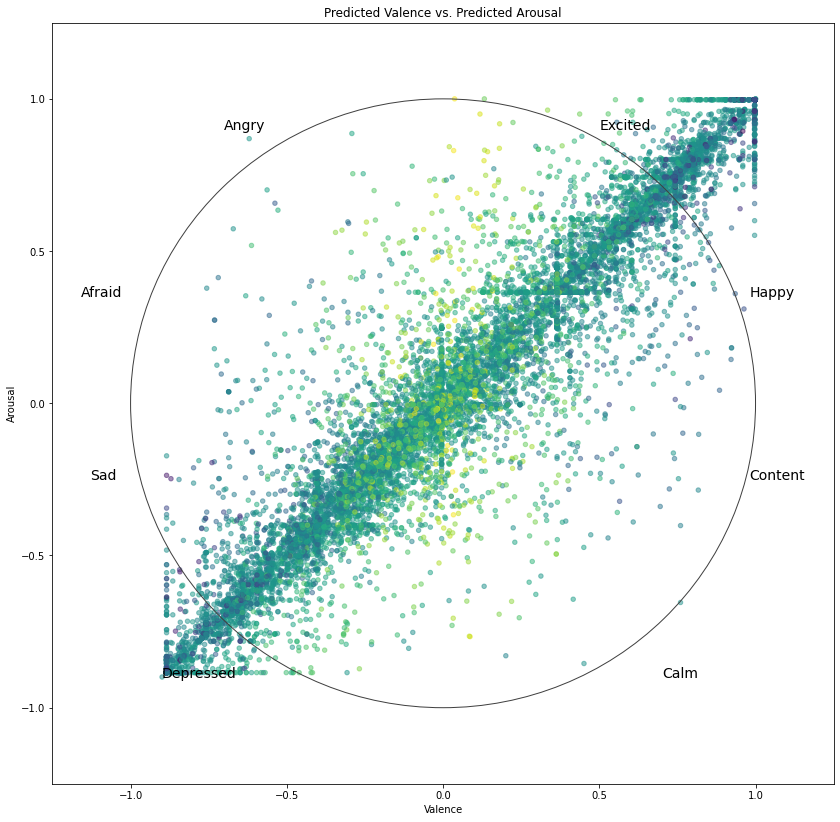

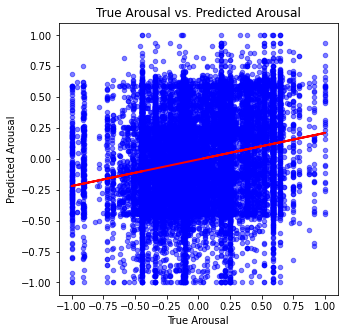

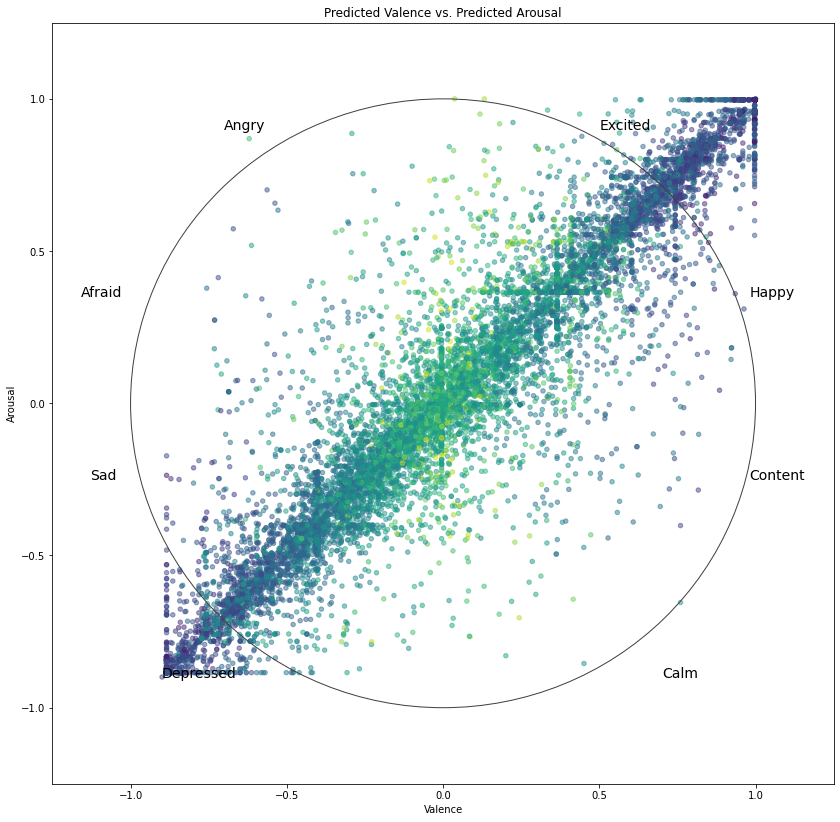

TODO FIX BELOW :(
df_ytube_feats valence mse 0.12343696909716068
df_ytube_feats arousal mse 0.12280265856592856
df_spot_feats valence mse 0.12343696909716068
df_spot_feats arousal mse 0.12280265856592856
df_all_feats valence mse 0.12343696909716068
df_all_feats arousal mse 0.12280265856592856


In [24]:
# TODO: clf is a stand in until I figure out tuning in exp1
clf = tree.DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
df_ytube_feats.name = 'df_ytube_feats'
df_spot_feats.name = 'df_spot_feats'
df_all_feats.name = 'df_all_feats'
datasets = [df_ytube_feats, df_spot_feats, df_all_feats]
vmse = exp2(clf, datasets= datasets)

## Experiment #3 - Quantity of Data

In `df_ytube_feats` [Set 2], the feature `'yt_comment_len'` tells the number of words found for that particular song.

Our **hypothesis** is that the longer the Youtube comments (in number of words), the better we can predict valence and arousal. 

Explore this hypothesis in an experiment:

* Use your best model and parameters from Experiment #1.
* Use the best dataset from Experiment #2 (Set 2, 3, or 4). 
* Predict valence and arousal for varying length of comments.
  * Iterate over $n=0, 1000, 2000, 3000, ..., 10000$ words (step-size $1000$).
    * filter data based on number of words in `'yt_comment_len'`
    * e.g., 0 words means use all songs, 1000 words means use only songs where `'yt_comment_len' >= 1000`, etc.
    * be careful not to drop forever from your original dataframes (i.e. use copies)
  * Save the correlation of the predictions for both valence and arousal for each value of $n$ words.
* Graph $n$ words (`x`-axis) against the Pearson's $r$ (`y`-axis) correlation.
  * include valence and arousal on same line graph.



In [0]:
# train_and_test_CV(clf, X, y, k=4):
# splitter(df, predictor='valence')
def exp3(clf, dataset):
  pears = []
  xs = [i for i in range(0, 11000, 1000)]
  for i in range(0, 11000, 1000):
    X, y = splitter(dataset.query('yt_comment_len >= ' + str(i)), predictor='valence')
    # y_pred, pears = train_and_test_CV(clf, X, y, k=6)
    _, pear = train_and_test_CV(clf, X, y, k=6)
    pears.append(pear)
  plt.plot(xs, pears, label='valence')
  pears = []
  for i in range(0, 11000, 1000):
    X, y = splitter(dataset.query('yt_comment_len >= ' + str(i)), predictor='arousal')
    # y_pred, pears = train_and_test_CV(clf, X, y, k=6)
    _, pear = train_and_test_CV(clf, X, y, k=6)
    pears.append(pear)
  plt.plot(xs, pears, label='arousal')
  plt.xlabel('n')
  plt.ylabel('pearsons')
  plt.legend(loc="upper left")
  plt.show()
    

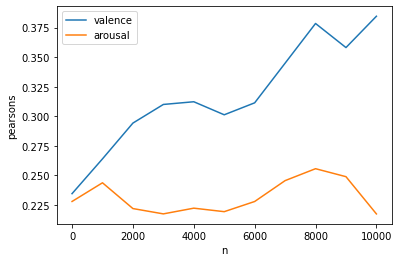

In [86]:
exp3(clf, df_all_feats)

## Experiment #EC - Extra Credit

This is an optional task worth up to $+10$ points extra credit.

Combine the song lyric features in `df_lyrics` with our youtube and spotify features to attempt to further improve your results. Only 13,526 have lyrics and you may drop the songs without lyrics.

You may choose any algorithm/parameters and any subset/transformation of features. Report and explain your findings. 

Use a feature selection or feature ranking approach to determine the most useful features (e.g., top ten best features) and explain your findings.

In [0]:
# code

***
# Lab Report
***

#### Directions

For each of your three experiments (and the EC) above, complete a mini-report. Each should include a paragraph (or more) for each of the following sections. 
 1. Problem Statement
 1. Methods
 1. Results
 1. Discussion
 1. Conclusion

You do not need to document your Pre-work in the Report.

#### Tips

**You will be graded on your report below** (not on your code above).  

* Write in complete sentences. Take pride in your write-up. 
* Proof-read your work. Lazy reports receive medicore grades.  
* Intermingle text and code. You will call your experiments and display your graphs directly in the report.  
* Explain and justify all your experimental design choices.
* In your discussion, convey your understanding of your results (don't just describe your graphs). 
* Label your graph and make them pretty. Use color.

***
## Report Experiment #1
***

*lorem ipsum ...* 

***
## Report Experiment #2
***

*lorem ipsum ...* 

***
## Report Experiment #3
***

*lorem ipsum ...* 

***
## Report Experiment #EC
***

*lorem ipsum ...* 